In [1]:
##
#     Libraries
####

import pandas as pd
import numpy as np
import os
import math
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from matplotlib.pyplot import cm
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import spatial
import numpy.matlib
import gc
import copy
from sklearn.model_selection import KFold
from outliers import smirnov_grubbs as grubbs

pd.__version__


'0.25.3'

# Functions to read feature files into a dataset

In [2]:
import decimal
import itertools
decimal.getcontext().rounding = decimal.ROUND_DOWN

def check_file_list(files,id_list=[],sec_list=[],day_list=[],treatment_list=[],celltype_list=[]):
    newFiles = []
    for f in files:
        include=True
        if len(f.split("_")) > 5:
            ms, day, cond, cell, sec, xtra = f.split("_")
        else:
            ms, day, cond, cell, sec = f.split("_")
            sec = sec[:-4]

        if day_list:
            include = include and (day in day_list)
        if id_list:
            print(ms,": ,",(ms in id_list))
            include = include and (ms in id_list) #(ms.upper() in map(lambda x:x.lower(),id_list))
        if treatment_list:
            include = include and (cond in treatment_list)
        if sec_list:
            print(sec,": ,",(sec in sec_list))
            print(sec_list)
            include = include and (sec in sec_list)
        if celltype_list:
            print(f"cell: {cell in celltype_list}")
            include = include and (cell in celltype_list)
        if include:
            newFiles.append(f)
        print(f,": ",f.split("_"),": ",include)
    return newFiles
    

##
# 
# Iter through all sections as grouped by cell type and ID
#s if splitByTreatment: 
#        return a list of [untreated, treated] sections, order is not preserved, treatment determined by treatmentCol
#######

def iter_mice_sections2(mice,cell="microglia",control="noFUS",treatment="FUS",treatmentCol="Treatment",splitByTreatment=True, index=["CellType","ID","Section","Treatment",'Boxsize','Threshold',"boxID"]):
    mice = mice.set_index(index)
    x = mice.xs(cell,level="CellType",drop_level=False)
    for index, df in x.groupby(level=["ID","Section"]):
        print(index)
        treatments = df.index.get_level_values(treatmentCol)
        if ((control in treatments) and (treatment in treatments)):
            result = df.reset_index()
            if splitByTreatment:
                con = df.xs(control,level="Treatment",drop_level=False)
                trt = df.xs(treatment,level="Treatment",drop_level=False)
                result = [con.reset_index(), trt.reset_index()]
            yield result
        else:
            print('ITER PROBLEM')
        
        
def set_box_id(mice):
    mice.loc[:,"boxID"] = np.arange(0,len(mice))
    return mice
'''
#returns a list of dataframes split from a larger dataframe over the values of a defined column
def split_column(df,col="Treatment",control="noFUS",treatment="FUS"):
    return df.loc[df[col]==control], df.loc[df[col]==treatment]
'''
def round_digits(df,features=['BX','BY']):
    df.loc[:,features] = df[features].astype('float').round(1)
    return df

def add_all_cell_data2(mice,boxsize=150,
                       path="G:/lab_files/imageJ_macro_working_directory/Gfap_Iba1_ki67/GFAP_Iba1_ki67_output/output_whole/microglia/cell_counts/counts/",
                      nnd=True, id_list=[], day_list=[], treatment_list=[],sec_list=[], centers=['X','Y'], fill_nan=True, slide=2,
                      ):
    begin=time.time()
    files = os.listdir(path)
    if (id_list) or (day_list) or (treatment_list) or (sec_list):
        files = check_file_list(files,id_list=id_list,day_list=day_list,treatment_list=treatment_list,sec_list=sec_list)
        print(files)
    keys = ["ID","Day","Treatment","Section","CellType",'Boxsize']
    to_add = []
    for f in files:
        print(f)
        st = time.time()
        ms, day, cond, cell, sect = f.split("_")
        sec = pd.read_csv(path+f,"\t")
        sec = sec.rename(columns={" " : "cellID"})
        
        for k,t in zip(keys,[ms,day,cond,sect[:-4],cell,boxsize]):
            sec.loc[:,k] = t
        if nnd:
            nnd_df = construct_nnd_df(sec, xy=centers)
            sec = pd.merge(sec, nnd_df, on=centers)
            
            to_add.append(sec)
         
    to_add = pd.concat(to_add,ignore_index=True)
    mice = add_cell_data3(mice,to_add)
    
    mice.loc[:,'ave_nnd'] = mice['sum_cell_nnd'] / mice['cell_counts']
    mice.loc[:,'ave_soma_size'] = mice['sum_cell_area'] / mice['cell_counts']
    mice.loc[:,'ave_soma_circularity'] = (4* np.pi * mice['sum_cell_area']) / (mice['sum_cell_perim_squared']) #4Ï€â€…Ã—â€…[Area] / [Perimeter]**2
    
    if fill_nan:
        fill = {}
        for c in ['ave_nnd','ave_soma_size','ave_soma_circularity','cell_counts']:
            fill[c] = 0
        mice.fillna(fill, inplace=True)
    
    print('total_time: ', time.time()-begin)
    return mice

def align_cellfeats_index(cells,index_names,index,xy=['BX','BY'],decimals=3):
    for k, v in zip(index_names,index):
        cells.loc[:,k] = v
    #cells.loc[:,xy] = cells[xy],d
    return cells.set_index(index_names+xy)

def get_ranges2(rangeinindex,xy,slide=2,slide_size=100):
    range_ = np.unique(rangeinindex.index.get_level_values(xy))
    ranges = []
    for i in range(0,slide):
        _ = np.arange(i,len(range_),slide)
        #for cut need to add one more upper boundary so the previous upper boundary is considered
        last = range_[_[-1]]
        grid = range_[_]
        
        grid = np.append(grid,[last+slide_size])
        ranges.append(grid)
    return ranges

def add_cell_data3(main, cells, indeces=['CellType','ID','Day','Treatment','Section','Boxsize'],xy=['BX','BY'],cell_centers=['X','Y'],boxsize=150,scale=1.5,slide=2,decimals=1,skipfirstlines=2):
    counting_frames = []
    cells.loc[:,'perim_squared']=cells['Perim.']**2
    to_add = cells[indeces+cell_centers+['Area','Perim.','perim_squared','cellID','nnd']]
    square_length = boxsize / scale 
    skew = boxsize / scale / slide
    print(square_length)
    
    all_frameshifts = []
    for x in range(0, slide):
        for y in range(0, slide):
            x_range = ((to_add[cell_centers[0]] - (skew * x)) / square_length) #subtract 50
            y_range = ((to_add[cell_centers[1]] - (skew * y)) / square_length)
            to_add.loc[:,'grid_x'] = x_range
            to_add.loc[:,'grid_y'] = y_range
            x_range = x_range.loc[x_range>=0].apply(int) #int(-0.###) == 0 which is incorrect assignment
            y_range = y_range.loc[y_range>=0].apply(int)
            
            to_add.loc[:,xy[0]] = round(x_range * square_length + (skew * x))
            to_add.loc[:,xy[1]] = round(y_range * square_length + (skew * y))
            
            #print(to_add)
            all_frameshifts.append(copy.copy(to_add))
    
    to_add = pd.concat(all_frameshifts)
    to_add = to_add.dropna(subset=['BX','BY'])

    main = main.set_index(indeces+xy)
    to_add = to_add.groupby(indeces+xy)[['cellID','Area','perim_squared','nnd']].agg({'cellID':'count',
                                                                             'Area': 'sum',
                                                                             'perim_squared': 'sum',
                                                                             'nnd': 'sum'})
    to_add = to_add.rename(columns = {'cellID' : 'cell_counts',
                                      'Area':'sum_cell_area', 
                                      'perim_squared' : 'sum_cell_perim_squared',
                                      'nnd': 'sum_cell_nnd'})
    
    for col in to_add.columns.values:
        st = time.time()
        main.loc[to_add.index,col] = to_add[col]
        print('time per col: ', time.time()-st)
    return main.reset_index()

def do_kdtree(xy,points):
    mytree = spatial.cKDTree(xy)
    return mytree.query(points,k=2) # dist, index
    
def get_nnd(xy):
    dist, ind = do_kdtree(xy,xy)
    point1=xy
    point2=xy[ind[:,1]]
    distances=dist[:,1]
    return point1, point2, distances

def construct_nnd_df(df,xy=['X','Y']):
    p1, p2, d = get_nnd(df[xy].values)
    comb = np.column_stack((p1,d))
    return pd.DataFrame(comb,columns=xy+['nnd'])


#read the brain section features file which is identified by mouseID, day, treatment, celltype, sectionID
#return a pd.dataframe containing a section's main features
def read_mouse_features_file(file,path="",delim="\t",boxsize=150,scale=1.5):
    f = f"{path}/{file}"
    d = pd.read_csv(f,delimiter=delim)
    ms, day, cond, cell, sect, start = file.split("_")
    keyList = ["ID","Day","Treatment","Section","CellType","Boxsize","Scale"]
    infoList = [ms,day,cond,sect,cell,boxsize,scale]
    for key, info in zip(keyList,infoList):
        d[key] = [info]*len(d)
        
    return d
    
def read_mouse_features(path="",delim="\t",boxsize=150,scale=1.5,filetype="features",
                        id_list=[],day_list=[],treatment_list=[],sec_list=[],celltype_list=[]):
    mice = []
    files = os.listdir(path)
    if (id_list) or (day_list) or (treatment_list) or (sec_list) or (celltype_list):
        files = check_file_list(files,id_list=id_list,day_list=day_list,treatment_list=treatment_list,sec_list=sec_list,celltype_list=celltype_list)
        print(files)
    if filetype == "fractal":
        print("--- reading factal files ---")
        for f in files:
            print(f)
            mice.append(read_mouse_fractals2(f,path=path,delim=delim,boxsize=boxsize,scale=scale))
    elif filetype == "features":
        print("--- reading features files ---")
        for f in files:
            print(f)
            mice.append(read_mouse_features_file(f,path=path,delim=delim,boxsize=boxsize,scale=scale))
    allMice = pd.concat(mice,ignore_index=True)
    return allMice

def read_mouse_fractals2(file,path="",delim="\t",boxsize=150,scale=1.5):
    f = f"{path}/{file}"
    ms, day, cond, cell, sect, start = file.split("_")
    keyList = ["ID","Day","Treatment","Section","CellType","Boxsize","Scale"]
    infoList = [ms,day,cond,sect,cell,boxsize,scale]
    
    d = pd.read_csv(f,delimiter=delim)
    fractals = d.loc[d["D"]>0,["BX","BY","D"]]
    fractals.loc[:,["BX","BY"]] = d[["BX","BY"]].iloc[fractals.index - 1].values
    for key, info in zip(keyList,infoList):
        fractals.loc[:,key] = [info]*len(fractals)
    return fractals



def compile_feature_df(base_path = f"G:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Gfap_iba1-gfap-set_19-11-14/output/",
                       feature_extension = "/feature_files/single_threshold/", #path variables
                       count_extension = "/count_data/counts/", #path variables
                       extra_path="/150/",
                       count_data = False, #true if count data was included
                       _slide=2,
                       set_ = "set1",
                       IDs = [],
                       celltypes=['gfap'],
                       boxsize=150,
                       sections=[]
                      ):
    '''
    all in one convenience function to load various types of feature data and compile into a single datframe
    '''
    feature_dfs = []
    branch_feature_dfs = []
    fractal_dfs = []
    
    full_feat_path = f"{base_path}/{set_}/{feature_extension}/features/{extra_path}/"
    full_fractal_path = f"{base_path}/{set_}/{feature_extension}/fractal_dimension/datafiles/{extra_path}/"
    full_branch_path = f"{base_path}/{set_}/{feature_extension}/branch_features/{extra_path}/"

    feature_dfs.append(read_mouse_features(path=full_feat_path,boxsize=boxsize,filetype='features',treatment_list=[],id_list=IDs,celltype_list=celltypes,sec_list=sections))
    branch_feature_dfs.append(read_mouse_features(path=full_branch_path,boxsize=boxsize,filetype='features',treatment_list=[],id_list=IDs,celltype_list=celltypes,sec_list=sections))
    fractal_dfs.append(read_mouse_features(path=full_fractal_path,boxsize=boxsize,filetype='fractal',treatment_list=[],id_list=IDs,celltype_list=celltypes,sec_list=sections))

    feat_df = round_digits(pd.concat(feature_dfs))
    fract_df = round_digits(pd.concat(fractal_dfs))
    branch_df = round_digits(pd.concat(branch_feature_dfs))
    
    df = pd.merge(feat_df, fract_df,on=["BX","BY","ID","Day","Treatment","Section","CellType","Boxsize","Scale"], how="outer")
    df = pd.merge(df, branch_df, on=["BX","BY","ID","Day","Treatment","Section","CellType","Boxsize","Scale"], how="outer")
    
    #df = merge_feature_files(feat_df, fract_df,on=["BX","BY","ID","Day","Treatment","Section","CellType","Boxsize","Scale"])
    #df = merge_feature_files(df, branch_df, on=["BX","BY","ID","Day","Treatment","Section","CellType","Boxsize","Scale"])
    
    if count_data:
        cell_count_path = f"{base_path}/{set_}/{feature_extension}/{count_extension}/"
        print(cell_count_path)
        df = add_all_cell_data2(df,boxsize=boxsize,id_list=IDs,nnd=True,slide=_slide,
                                path=cell_count_path)
        gc.collect()

    return df

print('done')

done


In [3]:
df = compile_feature_df(f"G:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_iba1-gfap-set_19-11-14/output/",
                        celltypes=['iba1'],
                        set_ = "set4_one_model_no_contrast",
                        count_data=True
                       )


cell: True
JS16_7D_noFUS_iba1_sec6_150X150.txt :  ['JS16', '7D', 'noFUS', 'iba1', 'sec6', '150X150.txt'] :  True
cell: True
JS16_7D_noFUS_iba1_sec4_150X150.txt :  ['JS16', '7D', 'noFUS', 'iba1', 'sec4', '150X150.txt'] :  True
cell: True
JS16_7D_noFUS_iba1_sec2_150X150.txt :  ['JS16', '7D', 'noFUS', 'iba1', 'sec2', '150X150.txt'] :  True
cell: True
JS16_7D_FUS_iba1_sec6_150X150.txt :  ['JS16', '7D', 'FUS', 'iba1', 'sec6', '150X150.txt'] :  True
cell: True
JS16_7D_FUS_iba1_sec4_150X150.txt :  ['JS16', '7D', 'FUS', 'iba1', 'sec4', '150X150.txt'] :  True
cell: True
JS16_7D_FUS_iba1_sec2_150X150.txt :  ['JS16', '7D', 'FUS', 'iba1', 'sec2', '150X150.txt'] :  True
cell: True
JS14_7D_FUS_iba1_sec8_150X150.txt :  ['JS14', '7D', 'FUS', 'iba1', 'sec8', '150X150.txt'] :  True
cell: True
JS14_7D_FUS_iba1_sec6_150X150.txt :  ['JS14', '7D', 'FUS', 'iba1', 'sec6', '150X150.txt'] :  True
cell: True
JS14_7D_FUS_iba1_sec4_150X150.txt :  ['JS14', '7D', 'FUS', 'iba1', 'sec4', '150X150.txt'] :  True
cell: T

JS12_7D_FUS_iba1_sec4_75-0.txt :  ['JS12', '7D', 'FUS', 'iba1', 'sec4', '75-0.txt'] :  True
cell: True
JS12_7D_FUS_iba1_sec4_75-75.txt :  ['JS12', '7D', 'FUS', 'iba1', 'sec4', '75-75.txt'] :  True
cell: True
JS12_7D_FUS_iba1_sec2_0-0.txt :  ['JS12', '7D', 'FUS', 'iba1', 'sec2', '0-0.txt'] :  True
cell: True
JS12_7D_FUS_iba1_sec2_0-75.txt :  ['JS12', '7D', 'FUS', 'iba1', 'sec2', '0-75.txt'] :  True
cell: True
JS12_7D_FUS_iba1_sec2_75-0.txt :  ['JS12', '7D', 'FUS', 'iba1', 'sec2', '75-0.txt'] :  True
cell: True
JS12_7D_FUS_iba1_sec2_75-75.txt :  ['JS12', '7D', 'FUS', 'iba1', 'sec2', '75-75.txt'] :  True
cell: True
JS12_7D_noFUS_iba1_sec2_0-0.txt :  ['JS12', '7D', 'noFUS', 'iba1', 'sec2', '0-0.txt'] :  True
cell: True
JS12_7D_noFUS_iba1_sec2_0-75.txt :  ['JS12', '7D', 'noFUS', 'iba1', 'sec2', '0-75.txt'] :  True
cell: True
JS12_7D_noFUS_iba1_sec2_75-0.txt :  ['JS12', '7D', 'noFUS', 'iba1', 'sec2', '75-0.txt'] :  True
cell: True
JS12_7D_noFUS_iba1_sec2_75-75.txt :  ['JS12', '7D', 'noFUS', 

JS16_7D_FUS_iba1_sec4_0-0.txt
JS16_7D_FUS_iba1_sec4_0-75.txt
JS16_7D_FUS_iba1_sec4_75-0.txt
JS16_7D_FUS_iba1_sec4_75-75.txt
JS16_7D_FUS_iba1_sec2_0-0.txt
JS16_7D_FUS_iba1_sec2_0-75.txt
JS16_7D_FUS_iba1_sec2_75-0.txt
JS16_7D_FUS_iba1_sec2_75-75.txt
JS14_7D_FUS_iba1_sec8_0-0.txt
JS14_7D_FUS_iba1_sec8_0-75.txt
JS14_7D_FUS_iba1_sec8_75-0.txt
JS14_7D_FUS_iba1_sec8_75-75.txt
JS14_7D_FUS_iba1_sec6_0-0.txt
JS14_7D_FUS_iba1_sec6_0-75.txt
JS14_7D_FUS_iba1_sec6_75-0.txt
JS14_7D_FUS_iba1_sec6_75-75.txt
JS14_7D_FUS_iba1_sec4_0-0.txt
JS14_7D_FUS_iba1_sec4_0-75.txt
JS14_7D_FUS_iba1_sec4_75-0.txt
JS14_7D_FUS_iba1_sec4_75-75.txt
JS14_7D_FUS_iba1_sec2_0-0.txt
JS14_7D_FUS_iba1_sec2_0-75.txt
JS14_7D_FUS_iba1_sec2_75-0.txt
JS14_7D_FUS_iba1_sec2_75-75.txt
JS13_7D_noFUS_iba1_sec6_0-0.txt
JS13_7D_noFUS_iba1_sec6_0-75.txt
JS13_7D_noFUS_iba1_sec6_75-0.txt
JS13_7D_noFUS_iba1_sec6_75-75.txt
JS13_7D_noFUS_iba1_sec4_0-0.txt
JS13_7D_noFUS_iba1_sec4_0-75.txt
JS13_7D_noFUS_iba1_sec4_75-0.txt
JS13_7D_noFUS_iba1_sec4_75

JS16_7D_noFUS_iba1_sec4_75-75.txt
JS16_7D_noFUS_iba1_sec2_0-0.txt
JS16_7D_noFUS_iba1_sec2_0-75.txt
JS16_7D_noFUS_iba1_sec2_75-0.txt
JS16_7D_noFUS_iba1_sec2_75-75.txt
JS16_7D_FUS_iba1_sec6_0-0.txt
JS16_7D_FUS_iba1_sec6_0-75.txt
JS16_7D_FUS_iba1_sec6_75-0.txt
JS16_7D_FUS_iba1_sec6_75-75.txt
JS16_7D_FUS_iba1_sec4_0-0.txt
JS16_7D_FUS_iba1_sec4_0-75.txt
JS16_7D_FUS_iba1_sec4_75-0.txt
JS16_7D_FUS_iba1_sec4_75-75.txt
JS16_7D_FUS_iba1_sec2_0-0.txt
JS16_7D_FUS_iba1_sec2_0-75.txt
JS16_7D_FUS_iba1_sec2_75-0.txt
JS16_7D_FUS_iba1_sec2_75-75.txt
JS14_7D_FUS_iba1_sec8_0-0.txt
JS14_7D_FUS_iba1_sec8_0-75.txt
JS14_7D_FUS_iba1_sec8_75-0.txt
JS14_7D_FUS_iba1_sec8_75-75.txt
JS14_7D_FUS_iba1_sec6_0-0.txt
JS14_7D_FUS_iba1_sec6_0-75.txt
JS14_7D_FUS_iba1_sec6_75-0.txt
JS14_7D_FUS_iba1_sec6_75-75.txt
JS14_7D_FUS_iba1_sec4_0-0.txt
JS14_7D_FUS_iba1_sec4_0-75.txt
JS14_7D_FUS_iba1_sec4_75-0.txt
JS14_7D_FUS_iba1_sec4_75-75.txt
JS14_7D_FUS_iba1_sec2_0-0.txt
JS14_7D_FUS_iba1_sec2_0-75.txt
JS14_7D_FUS_iba1_sec2_75-0.tx

c:\users\joey_\miniconda3\envs\pytorch\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\joey_\miniconda3\envs\pytorch\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


time per col:  0.17459726333618164
time per col:  0.1555936336517334
time per col:  0.21339821815490723
time per col:  0.16207623481750488
total_time:  2.6499621868133545


# Functions to cluster glia

In [13]:
def subtract_section_background(sec,cut=True,background_correct=True):
    bg_row = sec.loc[sec['ground']=='background']
    bg = bg_row["Mean"].values[0]
    sec = sec.loc[~(sec['ground']=='background') & ~(sec['ground']=='foreground')]
    
    rmindex = sec.loc[sec["Mean"]>=bg].index
    sec.loc[rmindex,"analyze"] = 1
    sec.loc[:,"analyze"] = sec["analyze"].fillna(0)
    if cut:
        sec = sec.loc[sec["analyze"]==1]
        #print(f"length of sec {len(sec)}")
    return sec


def standard_scale(train, test, features=["Mean","IntDen","Area"],
                   dropna=True,newcols=True, scale='standard'):
    if newcols:
        for f in features:
            newFeat = f+"_raw"
            train.loc[:,newFeat] = train.loc[:,f]
            test.loc[:,newFeat] = test.loc[:,f]
    
    if dropna:
        train = train.dropna(subset=features)
        test = test.dropna(subset=features)

    if scale == 'standard':
        scaler = StandardScaler()
    elif scale == 'minmax':
        scaler = MinMaxScaler()
    
    scaler.fit(train[features])
    train.loc[:,features]=scaler.transform(train[features])
    test.loc[:,features]=scaler.transform(test[features])
    return train, test

def trim(X,feature="Mean",gt=True,threshold=-1):
    if gt:
        re = X.loc[X[feature] > threshold]
    else:
        re = X.loc[X[feature] < threshold]
    return re

def dbscan_cluster(data,features=["BX","BY"], minN=20, eps=None, label="proximal_clusters", return_labels=False,boxsize=150):
    #print(len(data))
    if eps == None:
        eps = math.sqrt((2.0*(boxsize/1.5)**2)) + 1

    print('minN: ',minN, 'epsilon: ',eps)
    clusterer=DBSCAN(min_samples=minN,eps=eps)
    clusters = clusterer.fit_predict(data[features])
    if return_labels:
        result = clusters
    else:
        data.loc[:,label] = clusters
        result = data
    return result

def get_focal_threshold(data,feature="IntDen",subsetby="outlier",cluster_name="proximal_clusters",default_threshold=99):
    threshold = default_threshold
    x = data
    if subsetby == "outlier":
        x = data.loc[data["outlier"] == -1]
    elif subsetby == cluster_name:
        x = data.loc[data[cluster_name]>-1]
    if len(x) > 0:
        x = x.sort_values(by=feature,ascending=True)
        threshold = scan_elbow(x[feature],default_threshold=default_threshold)
    return threshold

def find_elbow(curve):
    nPoints = len(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0] # draw a line between last point and first point
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))   #find the normal
    vecFromFirst = allCoord - firstPoint #draw lines from all points to the first point
    scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    distFromFirstParallel = np.sqrt(np.sum(vecFromFirstParallel ** 2, axis=1))
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    angle = np.arctan(distToLine[idxOfBestPoint]/distFromFirstParallel[idxOfBestPoint])
    return idxOfBestPoint,curve[idxOfBestPoint],distToLine[idxOfBestPoint]

def scan_elbow(c,penalty=0.05,min_curve_distance=0.5,default_threshold=99):
    sub = int(penalty * len(c))
    if sub == 0:
        sub = 1
    nIters = int(len(c)/sub)
    elbows = []
    elbow_distance = []
    for i in range(0,nIters):
        start = sub*i
        elbow = find_elbow(c.iloc[start:].values)
        elbows.append(elbow[1])
        elbow_distance.append(elbow[2])
    thresh = stats.mode(elbows).mode[0]
    threshindex = np.where(elbows==thresh)[0][0] # get first index where mode elbow point i.e. threshold value is reached.
    if(elbow_distance[threshindex] < min_curve_distance): # assess curvature at this point
        thresh = default_threshold
    return thresh



def process_focal_cluster(trt,focal_minN=5,focal_feature="IntDen",focal_thresh=None,return_thresh=False, 
                          subsetby="proximal_clusters"):
    
    if focal_thresh == None:
        focal_thresh = get_focal_threshold(trt,feature=focal_feature,subsetby=subsetby)
    print("focal threshold: ", focal_thresh)
    trt_f = trim(trt,feature=focal_feature,gt=True,threshold=focal_thresh)
    if len(trt_f) > 0:
        trt.loc[trt_f.index, "focal_clusters"] = dbscan_cluster(trt_f,minN=focal_minN,return_labels=True)
        trt.loc[:,"focal_clusters"] = trt["focal_clusters"].fillna(-1)
    else:
        trt.loc[:,"focal_clusters"] = -1
    if return_thresh:
        re = [trt,focal_thresh]
    else:
        re = trt
    return re

    
def iter_corrections(mice,features=["Mean","IntDen","D"],extra_scalers=["IntDen",'Circ.'], grouping_keys = ['Boxsize','CellType','ID','Treatment','Section']
                     ):
    result = []
    pcas = []
    pd.options.mode.chained_assignment = None
    sub_bg = []
    for index, section in mice.groupby(grouping_keys):
        print(index)
        sec = subtract_section_background(section,cut=True)
        sub_bg.append(sec)
    to_return = pd.concat(sub_bg)
    to_return.loc[:,'boxID'] = to_return.reset_index().index.values
    return to_return
        
def iter_clustering_one_model(train, test_series, features = ['IntDen','Mean','D'], groupby=['ID','Section','Treatment'],
                    gamma=0.1, nu=0.1, kernel='rbf', minN=20,eps=None,
                                  trim_feature='Mean', trim_threshold=-1,
                                  proximal_cluster_label="proximal_clusters",
                                  focal_cluster=True, focal_feature='Mean', focal_minN=5, boxsize=None
                   ):
    st = time.time()
    grouping_keys = ['ID','Section']
    test_series = test_series.set_index(groupby+['boxID'])
    test_sections = []
    
    if boxsize == None:
        boxsizes = train['Boxsize'].unique()
        if len(boxsizes) == 1:
            boxsize = boxsizes[0]
            print(boxsize)
        else:
            print("multiple boxsizes detected .. error")
            stop
        
    if eps == None:
        eps = math.sqrt((2.0*(boxsize/1.5)**2)) + 1

    clusterer = DBSCAN(min_samples=minN,eps=eps)
    
    st = time.time()
    classifier = svm.OneClassSVM(nu=nu,gamma=gamma,kernel=kernel)
    classifier.fit(train[features])
    print(f" fit time: {time.time()-st}")

    for groups, section in test_series.groupby(level=groupby):
        outliers = classifier.predict(section[features])
        section.loc[:,"outlier"] = outliers
        to_cluster = section.loc[((section["outlier"]==-1) & (section[trim_feature]>trim_threshold))]
        if len(to_cluster)>0:
            clusters = clusterer.fit_predict(to_cluster[['BX','BY']])
            section.loc[to_cluster.index, proximal_cluster_label] = clusters
            if focal_cluster:
                section = process_focal_cluster(section, focal_feature=focal_feature, focal_minN=focal_minN)
        test_sections.append(section)
        
    return pd.concat(test_sections).reset_index()
    
                    
    
def iter_all_one_model(mice,cells=['iba1'],features=["Mean","IntDen","D"],extra_scalers=["IntDen",'Circ.','Mean'],
                           control="noFUS",treatment="FUS",
                           cross_validate_one_group=False, CVs = 5, CV_groups=['L','R'],
                       scale='standard',
                           proximal_cluster=True,gamma=0.1, nu=0.1, kernel='rbf',minN=20,eps=None,
                           focal_cluster=True,focal_minN=5,focal_feature="IntDen",
                           pca=True,n_comps=3,return_pca_model=False,
                          relabel_clusters=True, combine=False, label_unclustered=True, unclustered_reference='proximal_clusters',
                          groupby=['ID','Section','Treatment']):

    input_features = features
    df = iter_corrections(mice,features=features, extra_scalers=extra_scalers)
    
    train = df.loc[df['Treatment']==control]
    test = df.loc[df['Treatment']==treatment]

    train, test = standard_scale(train,test,features=features+extra_scalers,dropna=True,newcols=True, scale=scale)
    df = pd.concat([train,test]).reset_index()
        
    if pca:
        train = df.loc[df['Treatment']==control]
        test = df.loc[df['Treatment']==treatment]

        pca_model=PCA(n_components=n_comps).fit(train[features])
        print(pca_model.explained_variance_ratio_, 'explains: ',pca_model.explained_variance_ratio_.sum())
        train = assign_components(train, pca_model.transform(train[features]))
        test = assign_components(test, pca_model.transform(test[features]))


        df = pd.concat([train, test]).reset_index()
        c = np.array(['pca_']*n_comps)
        pca_features = list(np.core.defchararray.add(c, np.arange(n_comps).astype(str)))
        input_features = pca_features
        
    
    if cross_validate_one_group:
        all_series = []
        series = df.loc[df['Treatment'].isin(CV_groups)]
            
        kf = KFold(n_splits=CVs, shuffle=True, random_state=42)
        
        series = series.set_index(groupby)
        indexes = series.index.unique()
        for train_index, test_index in kf.split(indexes):
            
            X_train, X_test = series.loc[indexes[train_index]], series.loc[indexes[test_index]]
            test_sections = iter_clustering_one_model(X_train.reset_index(), X_test.reset_index(), 
                                                      features=input_features, gamma=gamma, nu=nu, kernel=kernel, 
                                                      minN=minN,
                                                     focal_cluster=focal_cluster, focal_feature=focal_feature, focal_minN=focal_minN)
            all_series.append(test_sections)
        return_df = pd.concat(all_series)
    
    else:
        train = df.loc[df['Treatment']==control]
        test_series = df.loc[df['Treatment']==treatment]
        test_series = iter_clustering_one_model(train, test_series, features=input_features, 
                                                gamma=gamma, nu=nu, kernel=kernel,minN=minN,
                                               focal_cluster=focal_cluster, focal_feature=focal_feature, focal_minN=focal_minN)
        return_df = pd.concat([test_series, train])
        
    if relabel_clusters:
        relabel = ['proximal_clusters']
        if focal_cluster:
            relabel = relabel+['focal_clusters']
        return_df = relabel_clusters2(return_df, clusters=relabel)
        
    if combine:
        return_df = combine_clusters(return_df)
        return_df = subtract_clusters(return_df)
    
    if label_unclustered:
        return_df = assign_unclustered(return_df, cluster=unclustered_reference)
        
    return return_df
    
def relabel_clusters2(df,clusters=["proximal_clusters","focal_clusters"]):
    df = df.reset_index(drop=True)
    for cl in clusters:
        f = lambda x: 1 if x > -1 else -1
        df.loc[:,cl] = df[cl].apply(f)
    return df
    #return df

def col_to_numeric(df,col):
    if type(col) is list:
        for c in col:
            df.loc[:,c]= pd.to_numeric(df[c])
    else:
        df.loc[:,col]= pd.to_numeric(df[col])
    return df

def count_focal_clusters(mice):
    mice = mice.set_index(["CellType","ID","Day","Section","Treatment","BX","BY","boxID"])
    for indexes, df in mice.groupby(level=["ID","Day","Treatment","CellType","Section"]):
        print(indexes)
        print(len(df.loc[df["focal_clusters"]>-1]))

def combine_clusters(mice,baseline="proximal_clusters",add="focal_clusters",label="combined_clusters"):
    mice.loc[:,label] = mice[baseline]
    mice = mice.set_index(["CellType","ID","Day","Section","Treatment","BX","BY","boxID"])
    for indexes, df in mice.groupby(level=["ID","Day","Treatment","CellType","Section"]):
        print(indexes)
        toadd = df.reset_index().set_index(["CellType","ID","Day","Section","Treatment","BX","BY","boxID",baseline,add])
        if 1 in toadd.index.get_level_values(add):
            toadd = toadd.xs((-1,1),level=(baseline,add))
            if len(toadd) > 0:
                print(len(toadd))
                mice.loc[toadd.index,label] = 1
    return mice.reset_index()

def subtract_clusters(mice,baseline="proximal_clusters",subtract="focal_clusters",label="subtracted_clusters"):
    mice.loc[:,label] = mice[baseline]
    mice = mice.set_index(["CellType","ID","Day","Section","Treatment","BX","BY","boxID"])
    for indexes, df in mice.groupby(level=["ID","Day","Treatment","CellType","Section"]):
        print(indexes)
        tosub = df.reset_index().set_index(["CellType","ID","Day","Section","Treatment","BX","BY","boxID",subtract])
        if 1 in tosub.index.get_level_values(subtract):
            tosub = tosub.xs(1,level=subtract)
            mice.loc[tosub.index,label] = -1
            print("length proximal:",len(mice.loc[mice[baseline]==1]),
                  "length of subtract:",len(tosub),
                  "length of result", len(mice.loc[mice[label]==1]))
    return mice.reset_index()

def assign_unclustered(mice,label="unclustered",cluster="combined_clusters"):
    index = mice.loc[mice["analyze"] == 1].index
    mice.loc[index,label] = mice[cluster]*-1
    mice.loc[:,label] = mice[label].fillna(-1)
    return mice
    
def write_cluster_file(df,file,path=""):
    boxes = (df["BX"]*df["Scale"]).astype(str) + "-" + (df["BY"]*df["Scale"]).astype(str) + "-" + (df["Boxsize"]).astype(str) + "="   #(df["Boxsize"]*df["Scale"]).astype(str)
    #boxes = df.BX.astype(str) + "-" + df.BY.astype(str) + "-" + df.Boxsize.astype(str) + "="
    boxes = boxes.tolist()
    str1 = ''.join(boxes)
    str1 = str1[:-1]
    if len(str1) > 0:
        with open(path+"/"+file, 'w') as w:
            w.write(str1)
            return True
    else:
        return False
    
def write_all_cluster_files(df,clusters=["proximal_clusters","focal_clusters"],cell="microglia",
                            path="F:\\lab_files/imageJ_macro_working_directory/Gfap_Iba1_ki67/GFAP_Iba1_ki67_output/input_cluster_files/novel_outlier",
                           subdir="", write_unclustered=True, unclustered_reference = 'combined_clusters', unclustered_output="unclustered"):
    mice = df.set_index(["CellType","ID","Day","Section","Treatment"]+clusters)
    unclustered_path = f"{path}/{subdir}/{unclustered_output}/"
    for c in clusters:
        print(c)
        for indexes, df in mice.groupby(level=["ID","Day","Treatment","CellType","Section"])["BX","BY","Boxsize"]:
            file = "_"
            file = file.join(list(indexes))+".txt"
            '''
            for v in indexes:
                file += v+"_"
            file = file[0:-1]+".txt"
            '''
            print(file)
            values = df.index.get_level_values(c)
            if 1 in values:
                x = df.xs(1, level=c,drop_level=False)
                wrote = write_cluster_file(x,file,path=path+"/"+subdir+"/"+c.replace("_clusters",""))
            else:
                print(indexes, "no clusters")
                if write_unclustered:
                    if c == unclustered_reference:
                        with open(unclustered_path+file,'w') as w:
                            print("wrote unclustered")
                            w.write("")

                
def write_cluster_files_groupby_boxsize_threshold(data,cell='microglia',path="F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\microglia_astrocyte_7D_output\\cluster_files\\cluster_datafiles\\"
                                                  ,clusters=['proximal_clusters','focal_clusters'],
                                                 write_unclustered=True, unclustered_reference = 'combined_clusters', unclustered_output="unclustered"):
    for index, df in data.groupby(['Threshold','Boxsize']):
        subdir = str(index[0]) + "/" + str(index[1]) + "/"
        print(subdir)
        write_all_cluster_files(df,clusters=clusters,cell=cell,path=path,subdir=subdir, write_unclustered=write_unclustered, unclustered_reference=unclustered_reference, unclustered_output=unclustered_output)


def assign_components(df,pca):
    for i in range(0,len(pca[0])):
        col="pca_"+str(i)
        df.loc[:,col]=pca[:,i]
    return df

#input a section, outputs PCA transformed nf and f data in the section
def pca_section(con,trt, n_comps=3,features=["Mean","Area","D"], return_pca_model=False):
    pca=PCA(n_components=n_comps).fit(con[features])
    con = assign_components(con, pca.transform(con[features]))
    trt = assign_components(trt, pca.transform(trt[features]))
    print(pca.explained_variance_ratio_, 'explains: ',pca.explained_variance_ratio_.sum())
    if return_pca_model:
        return con, trt, pca
    
    else:
        return con, trt

print('done')

done


In [11]:
def plot_mice(sec,features=["BX","BY"],colour_features=["proximal_clusters"],plot='scatter',xlabel=None,ylabel=None, invert_y=False, invert_x=False,
              colours=None,size=None, labels=None, save=False, outputfile='output.png', fontsize=14, vmin=-2.5, vmax=2.5, 
              legend_font=10,legend_loc='upper left', legend=True,cbar=True, fig_size = [2.66,2.66], alpha=0.7, transparent=True):
    if labels:
        labels = iter(labels)
    if sec is type(list):
        print("not implemented")
    else:
        if plot=='density':
            sec = set_colours2(sec,colour_features=colour_features)
            fig, ax = plt.subplots()
            ax.set_xlabel(xlabel,fontsize=fontsize)
            ax.set_ylabel(ylabel,fontsize=fontsize)
            if colours:
                print('true')
                cmaps = iter(colours)
                print(cmaps)
            else:
                cmaps = {'focal' : 'Purples',
                        'proximal' : 'Reds',
                        'unclustered' : 'Greens',
                        'untreated' : 'Blues'}
                
            sec = sec.sort_values(by='colour_categories')
            for indexes, df in sec.groupby(["colour_categories",'cluster_name']):
                print(indexes)
                Xs=df[features[0]].values
                Ys=df[features[1]].values
                
                print('length of feats,', len(Xs))
                if labels:
                    label = next(labels)
                    print(label)
                else:
                    label = indexes[1]
                try:
                    cmap = next(cmaps)
                except:
                    cmap = cmaps[label]
                
                print('label, ',label, ' cmap, ',cmap)
                sns.kdeplot(Xs, Ys, shade=False,  label=label, bw=.15, legend=False, shade_lowest=False) 
                
        elif plot == 'scatter':
            fig = plt.figure()
            if fig_size:
                fig.set_size_inches(fig_size)
            ax1 = plt.subplot(111)
            ax1.set_xlabel(xlabel, fontsize=fontsize)
            ax1.set_ylabel(ylabel, fontsize=fontsize)
            sec = set_colours2(sec,colour_features=colour_features)
            n = len(np.unique(sec["colour_categories"]))
            if colours:
                colours = iter(colours)
            else:
                colours=iter(cm.rainbow(np.linspace(0,1,n)))
            if labels:
                labels = iter(labels)
            for indexes, df in sec.groupby(["colour_categories","cluster_name"]):
                Xs=df[features[0]]
                Ys=df[features[1]]
                c = next(colours)
                if labels:
                    label = next(labels)
                else:
                    label = indexes[1]
                ax1.scatter(Xs,Ys,c=c,label=label, alpha=alpha)
                
        elif plot == 'heatmap':
            fig, ax = plt.subplots()
            fig.set_size_inches([2.66,2.66])
            
            print(xlabel,ylabel)
            p = sec[features]
            p = p.rename(index=str, columns={features[0]: ylabel, features[1]: xlabel})
            pivot = p.pivot(ylabel,xlabel,features[2])
            
            sns.heatmap(pivot,annot=False,ax=ax,cmap=colours,vmin=vmin,vmax=vmax, xticklabels=[],yticklabels=[],cbar=cbar)

        plt.axis('scaled')
        
        if legend:
            plt.legend(fontsize=legend_font,loc=legend_loc)
        if invert_y:
            plt.gca().invert_yaxis()
        if invert_x:
            plt.gca().invert_xaxis()
        if save:
            plt.tight_layout()
            plt.savefig(outputfile, dpi=300, transparent=transparent)
        
        plt.show()
                
def plot_biplot(sec,features=["BX","BY"],
                colour_features=["proximal_clusters","unclustered"],
                label_clusters=True,
                plot_features=False,
                control="noFUS",treatment="FUS",
                cmap='viridis',vmin=None,vmax=None,colours=None,
               save=False, outputfile="output.png"):
    
    n=10
    if label_clusters:
        sec = set_colours2(sec,colour_features=colour_features)
        n = len(np.unique(sec["cluster_name"]))
        print(np.unique(sec["cluster_name"]))
        print(n)
        
    if colours == None:
        colours = iter(cm.rainbow(np.linspace(0,1,n)))
        
    fig = plt.figure()
    
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    
    p1 = sec.loc[sec["Treatment"]==control]
    p2 = sec.loc[sec["Treatment"]==treatment]
    
    ID_sec = sec[['ID','Section']].iloc[0].values
    graph_title = ID_sec[0]+"_"+ID_sec[1]
    
    if plot_features:
        print('only 3D')
        for ax, p in zip([ax1,ax2],[p1,p2]):
            p = p[features]
            pivot = p.pivot(features[1],features[0],features[2])
            sns.heatmap(pivot,annot=False,ax=ax,cmap=cmap,vmin=vmin,vmax=vmax)
                
    else:
        for ax, p in zip([ax1,ax2],[p1,p2]):
            for indexes, df in p.groupby(["cluster_name"]):
                Xs=df[features[0]]
                Ys=df[features[1]]
                c = next(colours)
                ax.scatter(Xs,Ys,c=c,label=df['colour_label'].unique()[0])
                ax.legend()
    plt.suptitle(graph_title)
    
    if save:
        plt.savefig(outputfile, dpi=300)
    plt.show()
    

def decode_clusters(sec, cluster_features = ['proximal_clusters','unclustered'], treatment_col = 'Treatment',
                    labels={'-1,-1,L' : 'control_left'},
    ):
    
    levels = cluster_features+[treatment_col]
    sec = sec.set_index(levels)
    
    for index, df in sec.groupby(level=levels):
        print(index)
        label = ",".join(map(str,index))
        if label in labels.keys():
            label = labels[label]
        sec.loc[index,'cluster_name'] = label
        
    return sec.reset_index()
    
def set_colours2(sec,colour_features=['proximal_clusters','unclustered'],treatment_col='Treatment', colour_order={'untreated' : 0,
                                                                                                          'unclustered' : 1,
                                                                                                          'proximal' : 2,
                                                                                                          'focal' : 3,
                                                                                                                 'noFUS_proximal' : 4}):
    
    sec = decode_clusters(sec, cluster_features = colour_features, treatment_col=treatment_col)
    levels = colour_features+[treatment_col]
    sec = sec.set_index(levels)
    cat = 0
    
    for index, df in sec.groupby(level = levels):
        cl = np.unique(sec.loc[index, 'cluster_name'])[0]
        order = 0
        if cl in colour_order.keys():
            order = colour_order[cl]
        sec.loc[index,'colour_categories'] = order
        
        cat_label = index[-1]
        _ = np.array(index[:-1])
        if 1 in _:
            cat_label += "_" + levels[np.where(_ == 1)[0][0]]
        else:
            cat_label += "_" + levels[np.where(_ == -1)[0][0]]
        sec.loc[index,'colour_label'] = " ".join(map(str,index))
        cat+=1
    return sec.reset_index().sort_values(by='colour_categories')

def get_section(mice,ID,sec):
    return mice.loc[(mice["ID"]==ID) & (mice["Section"]==sec)]

print('done')


done


(150, 'iba1', 'JS12', 'FUS', 'sec2')
(150, 'iba1', 'JS12', 'FUS', 'sec4')
(150, 'iba1', 'JS12', 'FUS', 'sec6')
(150, 'iba1', 'JS12', 'FUS', 'sec8')
(150, 'iba1', 'JS12', 'noFUS', 'sec2')
(150, 'iba1', 'JS12', 'noFUS', 'sec4')
(150, 'iba1', 'JS12', 'noFUS', 'sec6')
(150, 'iba1', 'JS12', 'noFUS', 'sec8')
(150, 'iba1', 'JS13', 'FUS', 'sec2')
(150, 'iba1', 'JS13', 'FUS', 'sec4')
(150, 'iba1', 'JS13', 'FUS', 'sec6')
(150, 'iba1', 'JS13', 'FUS', 'sec8')
(150, 'iba1', 'JS13', 'noFUS', 'sec2')
(150, 'iba1', 'JS13', 'noFUS', 'sec4')
(150, 'iba1', 'JS13', 'noFUS', 'sec6')
(150, 'iba1', 'JS13', 'noFUS', 'sec8')
(150, 'iba1', 'JS14', 'FUS', 'sec2')
(150, 'iba1', 'JS14', 'FUS', 'sec4')
(150, 'iba1', 'JS14', 'FUS', 'sec6')
(150, 'iba1', 'JS14', 'FUS', 'sec8')
(150, 'iba1', 'JS14', 'noFUS', 'sec2')
(150, 'iba1', 'JS14', 'noFUS', 'sec4')
(150, 'iba1', 'JS14', 'noFUS', 'sec6')
(150, 'iba1', 'JS14', 'noFUS', 'sec8')
(150, 'iba1', 'JS16', 'FUS', 'sec2')
(150, 'iba1', 'JS16', 'FUS', 'sec4')
(150, 'iba1', 

c:\users\joey_\miniconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in double_scalars
c:\users\joey_\miniconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide
c:\users\joey_\miniconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in double_scalars
c:\users\joey_\miniconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide


focal threshold:  99
focal threshold:  99
focal threshold:  99


c:\users\joey_\miniconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide


focal threshold:  99


c:\users\joey_\miniconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:250: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS12', '7D', 'FUS', 'iba1', 'sec2')
('JS12', '7D', 'FUS', 'iba1', 'sec4')
('JS12', '7D', 'FUS', 'iba1', 'sec6')
('JS12', '7D', 'FUS', 'iba1', 'sec8')
('JS12', '7D', 'noFUS', 'iba1', 'sec2')
('JS12', '7D', 'noFUS', 'iba1', 'sec4')
('JS12', '7D', 'noFUS', 'iba1', 'sec6')
('JS12', '7D', 'noFUS', 'iba1', 'sec8')
('JS13', '7D', 'FUS', 'iba1', 'sec2')
('JS13', '7D', 'FUS', 'iba1', 'sec4')
('JS13', '7D', 'FUS', 'iba1', 'sec6')
('JS13', '7D', 'FUS', 'iba1', 'sec8')
('JS13', '7D', 'noFUS', 'iba1', 'sec2')
('JS13', '7D', 'noFUS', 'iba1', 'sec4')
('JS13', '7D', 'noFUS', 'iba1', 'sec6')
('JS13', '7D', 'noFUS', 'iba1', 'sec8')
('JS14', '7D', 'FUS', 'iba1', 'sec2')
('JS14', '7D', 'FUS', 'iba1', 'sec4')
('JS14', '7D', 'FUS', 'iba1', 'sec6')
('JS14', '7D', 'FUS', 'iba1', 'sec8')
('JS14', '7D', 'noFUS', 'iba1', 'sec2')
('JS14', '7D', 'noFUS', 'iba1', 'sec4')
('JS14', '7D', 'noFUS', 'iba1', 'sec6')
('JS14', '7D', 'noFUS', 'iba1', 'sec8')
('JS16', '7D', 'FUS', 'iba1', 'sec2')
('JS16', '7D', 'FUS', 'iba

c:\users\joey_\miniconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py:3051: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\joey_\miniconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py:3319: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\users\joey_\miniconda3\envs\pytorch\lib\site-packages\pandas\core\indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
c:\users\joey_\miniconda3\envs\pytorch\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
c:\users\joey_\miniconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py:3242: PerformanceWarning: indexing past lexsort depth may impact performance.
  if 

=============== ['Area', 'Mean', 'D', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple', 'nEnds', 'totalBranchLength', 'Perim.'] ================
-----------------------------------
-----------------------------------
-----------------------------------
['sec2' 'sec4' 'sec6' 'sec8']
(-1, -1, 'FUS')
(-1, -1, 'noFUS')
(1, -1, 'FUS')
['-1,-1,FUS' '-1,-1,noFUS' '1,-1,FUS']
3


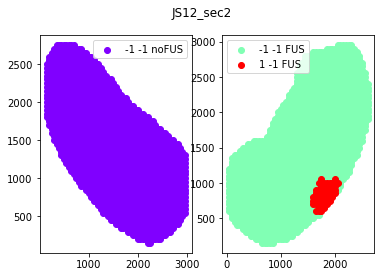

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

(-1, -1, 'FUS')
(-1, -1, 'noFUS')
(-1, 1, 'FUS')
(1, -1, 'FUS')
['-1,-1,FUS' '-1,-1,noFUS' '-1,1,FUS' '1,-1,FUS']
4


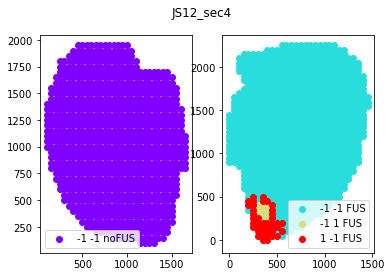

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(-1, -1, 'FUS')
(-1, -1, 'noFUS')
['-1,-1,FUS' '-1,-1,noFUS']
2


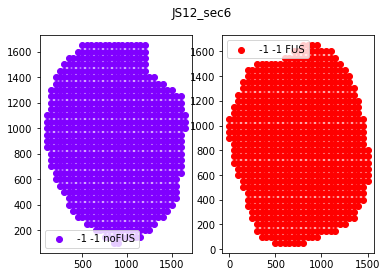

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(-1, -1, 'FUS')
(-1, -1, 'noFUS')
['-1,-1,FUS' '-1,-1,noFUS']
2


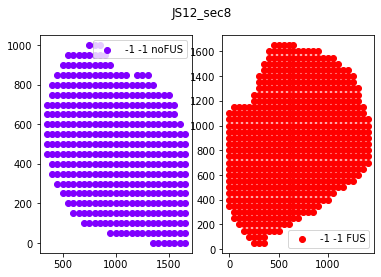

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

['sec2' 'sec4' 'sec6' 'sec8']
(-1, -1, 'FUS')
(-1, -1, 'noFUS')
(-1, 1, 'FUS')
(1, -1, 'FUS')
['-1,-1,FUS' '-1,-1,noFUS' '-1,1,FUS' '1,-1,FUS']
4


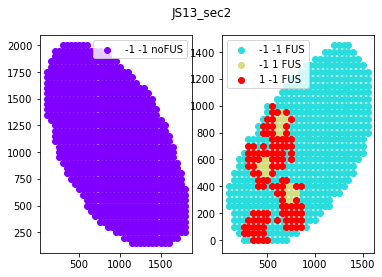

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(-1, -1, 'FUS')
(-1, -1, 'noFUS')
['-1,-1,FUS' '-1,-1,noFUS']
2


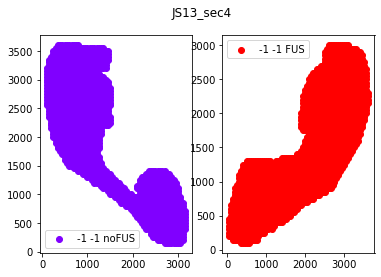

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

(-1, -1, 'FUS')
(-1, -1, 'noFUS')
(-1, 1, 'FUS')
(1, -1, 'FUS')
['-1,-1,FUS' '-1,-1,noFUS' '-1,1,FUS' '1,-1,FUS']
4


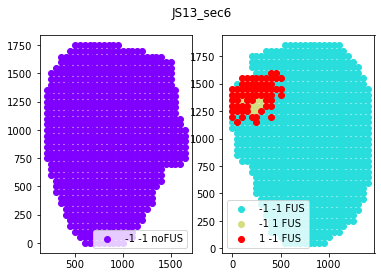

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(-1, -1, 'FUS')
(-1, -1, 'noFUS')
['-1,-1,FUS' '-1,-1,noFUS']
2


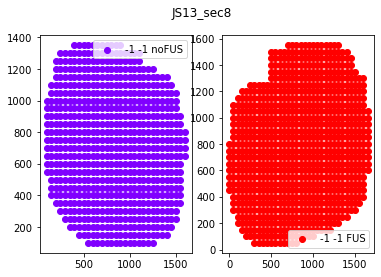

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

['sec2' 'sec4' 'sec6' 'sec8']
(-1, -1, 'FUS')
(-1, -1, 'noFUS')
(-1, 1, 'FUS')
(1, -1, 'FUS')
['-1,-1,FUS' '-1,-1,noFUS' '-1,1,FUS' '1,-1,FUS']
4


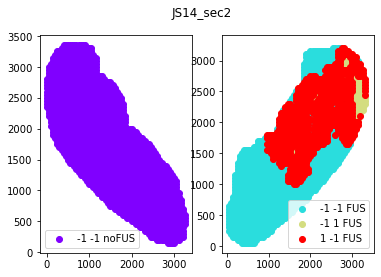

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(-1, -1, 'FUS')
(-1, -1, 'noFUS')
(1, -1, 'FUS')
['-1,-1,FUS' '-1,-1,noFUS' '1,-1,FUS']
3


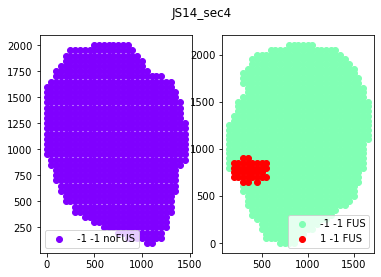

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

(-1, -1, 'FUS')
(-1, -1, 'noFUS')
(-1, 1, 'FUS')
(1, -1, 'FUS')
['-1,-1,FUS' '-1,-1,noFUS' '-1,1,FUS' '1,-1,FUS']
4


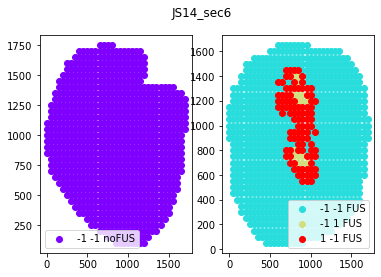

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(-1, -1, 'FUS')
(-1, -1, 'noFUS')
(1, -1, 'FUS')
['-1,-1,FUS' '-1,-1,noFUS' '1,-1,FUS']
3


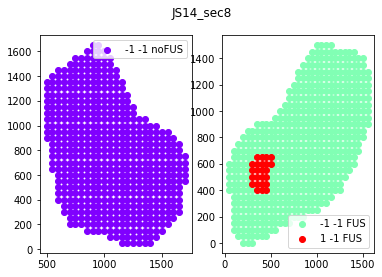

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['sec2' 'sec4' 'sec6']
(-1, -1, 'FUS')
(-1, -1, 'noFUS')
(1, -1, 'FUS')
['-1,-1,FUS' '-1,-1,noFUS' '1,-1,FUS']
3


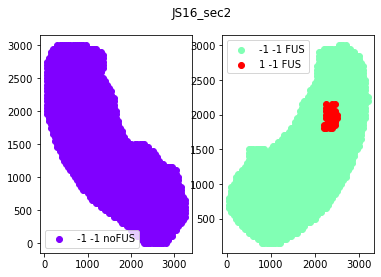

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(-1, -1, 'FUS')
(-1, -1, 'noFUS')
['-1,-1,FUS' '-1,-1,noFUS']
2


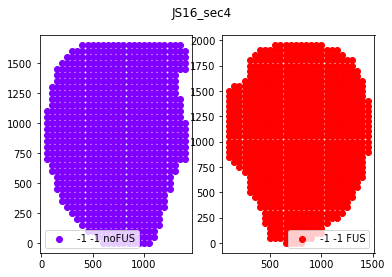

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(-1, -1, 'FUS')
(-1, -1, 'noFUS')
['-1,-1,FUS' '-1,-1,noFUS']
2


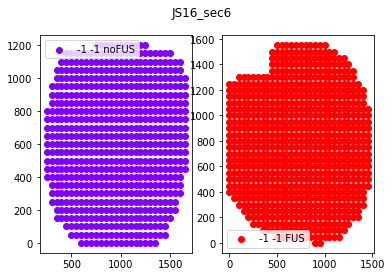

done


In [37]:
#to_use_features = "Area+Mean+D+cell_counts+ave_nnd+ave_soma_size+ave_soma_circularity+nJunctions+nBranches+nTriple+nEnds+totalBranchLength+Perim.".split("+")


to_use_features = "Area+Mean+D+ave_nnd+ave_soma_size+ave_soma_circularity+nJunctions+nBranches+nTriple+nEnds+totalBranchLength+Perim.".split("+")

#abcam iba1
#gamma = 0.25
#nu = 0.1
#minN = 18

#correct 1 model params
gamma = 0.2
nu=0.18
minN = 20


pca=True
n_pca=7
#'''

#'''
#wako_iba1
#gamma = 0.2
#nu = 0.22
#minN = 20

pca=True
n_pca=9

con = 'noFUS'
trt = 'FUS'
micro_clusters = []
micro_pca_models = []

return_pca_model=False

for df in [df]:
    clusters = iter_all_one_model(df, cells=['iba1'],features=to_use_features,
                           control=con,treatment=trt,
                                      cross_validate_one_group=False,CV_groups=['noFUS'],CVs=10,
                           extra_scalers=["IntDen",'Circ.'],scale='standard',
                           proximal_cluster=True,gamma=gamma, nu=nu, kernel='rbf',minN=minN,eps=None,
                           focal_cluster=True,focal_minN=5,focal_feature="Mean",
                           pca=True,n_comps=n_pca, 
                          relabel_clusters=True, combine=True, unclustered_reference='combined_clusters')
    
    
    if return_pca_model:
        micro_pca_models.append(clusters[1])
        clusters = clusters[0]

    micro_clusters.append(clusters)

micro_clusters = pd.concat(micro_clusters)

boxsize=150
for cluster in [micro_clusters]:
    print(f"=============== {to_use_features} ================")
    print(f"-----------------------------------")
    print(f"-----------------------------------")
    print(f"-----------------------------------")
    for ID in ['JS12','JS13','JS14','JS16']:
        ID_df = cluster.loc[cluster['ID']==ID]

        print(np.unique(ID_df['Section']))
        for sec in list(np.unique(ID_df['Section'])):
            for thresh in ['single_threshold']:
                s = get_section(cluster,ID,sec)
                s = s.loc[s['Boxsize']==boxsize]
                f = 'outlier'
                plot_biplot(s,features=['BX','BY',f],colour_features=['subtracted_clusters','focal_clusters'],control=con,treatment=trt,plot_features=False,vmin=-3,vmax=3,label_clusters=True)


                
                
write_clusters=False
if write_clusters:
    #write iba1-gfap-ki67 cluster files
    #base = f"E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_iba1-gfap-set_19-11-14/output/{_set}/"
    base = f"F:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_setTgf1b/output/{_set}/"
    path = base + "cluster_files/cluster_coordinates/"
    
    
    _set = 'set4_one_model_no_contrast'
    write_cluster_files_groupby_boxsize_threshold(micro_clusters,cell='iba1',
                                                  path=path,
                                                  #path=f"E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_setTgf1b/output/{_set}/cluster_files/cluster_coordinates/"
                                                  clusters=['proximal_clusters','focal_clusters','subtracted_clusters','combined_clusters'],
                                                 write_unclustered=True, unclustered_reference = 'combined_clusters', unclustered_output="unclustered")

    
    date="20-4-10"
    log_file = base+f"logs/{date}_log_file.txt"
    with open(log_file, 'w') as w:
        w.write(str(to_use_features))
        w.write(f"nu: {nu}, gamma: {gamma}, minN: {minN}, pca: {pca}, nPCA: {n_pca}")


print('done')

In [33]:
from sklearn.model_selection import ParameterGrid

def setup_grid_ranges(gamma_range=[0.05,0.15,3],nu_range=[0.08,0.2,6],minN_range=[10,24,7], nPCs=None, nFeatures=1, auto_modifier=0.7):
    gammas = np.linspace(gamma_range[0],gamma_range[1],gamma_range[2])
    nus = np.linspace(nu_range[0],nu_range[1],nu_range[2])
    minNs = np.linspace(minN_range[0],minN_range[1],minN_range[2])
    
    #order gammas > nus > minNs > nfeats 
    param_grid = {'nu' : np.around(nus,decimals=2),
             'minN' : np.around(minNs,decimals=0),
             'gamma' : np.around(gammas, decimals=2)}
    
    if nPCs:
        if nPCs == 'auto':
            param_grid['nPCs'] = np.linspace(round(auto_modifier*nFeatures), round(auto_modifier*nFeatures), 1)
        else:
            nPCs = np.linspace(nPCs[0],nPCs[1],nPCs[2])
            param_grid['nPCs'] = np.around(nPCs)
        
    take2 = pd.DataFrame(list(ParameterGrid(param_grid)), columns=param_grid.keys())
    return take2

def grid_search_one_model(mice,cell="microglia",features=[],control="L",treatment="R",reciprocal=False,
                          kernel='rbf', gamma_range=[0.05,0.15,3],nu_range=[0.08,0.2,6], minN_range=[10,26,7],
                          pca=False, n_pca_range = [6,13,3],scale='standard',
                          cross_validate_one_group=False, CVs=5, CV_groups=['L','R'],
                          focal_cluster=False,focal_minN=5,focal_feature="Mean",
                          summarize_clusters=False, summary_keys=['gamma','nu','min','ID','Section','Treatment'], 
                          summary_clusters=['proximal_clusters']):
    
    if pca:
        summary_keys = summary_keys+['nPCs']
    print('... setting up grid ranges ...')
    if pca:
        grids = setup_grid_ranges(gamma_range = gamma_range, nu_range=nu_range, minN_range = minN_range, nPCs=n_pca_range, nFeatures = len(features))
    else:
        grids = setup_grid_ranges(gamma_range = gamma_range, nu_range=nu_range, minN_range = minN_range)
    
    grids.loc[:,'cluster_size'] = 0
    grids.loc[:,'num_outliers'] = 0
    
    iterations = 0
    num_iterations = len(grids)
    print(f"----- number of iterations: {num_iterations} -----")
    clusters = []
    levels=['gamma','nu','minN']
    if pca:
        levels = levels + ['nPCs']

    grids = grids.set_index(levels)
    count_round=0
    for indexes, df in grids.groupby(level=levels):
        st = time.time()
        g = indexes[0]
        n = indexes[1]
        m = indexes[2]
        nPCs=0
        if pca:
            nPCs = indexes[3]
            
        clust = iter_all_one_model(mice,cells=[cell],features=features,extra_scalers=['Mean','D','IntDen','Circ.'],
                                   control=control,treatment=treatment,
                                   cross_validate_one_group=cross_validate_one_group, CVs = CVs, CV_groups=CV_groups,
                                   scale=scale,
                                   proximal_cluster=True,gamma=g, nu=n, kernel='rbf',minN=int(m),eps=None,
                                   focal_cluster=focal_cluster,focal_minN=focal_minN,focal_feature=focal_feature,
                                   pca=True,n_comps=int(nPCs),return_pca_model=False,
                                   relabel_clusters=True, combine=False, label_unclustered=False, 
                                   unclustered_reference='proximal_clusters', groupby=['ID','Section','Treatment'])
        
        clust.loc[:,'gamma'] = g
        clust.loc[:,'nu'] = n
        clust.loc[:,'min'] = m

        if pca:
            clust.loc[:,'nPCs'] = nPCs
        
        if summarize_clusters:
            clust = summarize_cluster_grids(clust, keys=summary_keys, cluster_types=summary_clusters)
        clusters.append(clust)
        
        iterations += 1
        if (iterations % 50) == 0:
            print(f"progress.. {iterations}/{num_iterations}")
        print(f"===== TIME FOR ITERATION {time.time()-st} -- #{count_round}/{num_iterations} =====")
        count_round += 1
    return pd.concat(clusters)

      
def plot_grid(grids,splitby='gamma',x='minN',y='nu',z='cluster_size',cmap='spectral',vmin=0,vmax=None):
    splits = grids.index.get_level_values(splitby).unique()
    fig = plt.figure()
    grids = grids[z]
    for plc, s in zip(range(len(splits)),splits):
        grid = grids.xs(s,level=splitby)
        grid = grid.reset_index()
        sub = 100 + len(splits)*10 + 1 +plc
        ax = fig.add_subplot(sub)
        grid = grid.pivot(x, y, z)
        ax = sns.heatmap(grid,cmap=cmap,vmin=vmin,vmax=vmax)
    plt.show()

def rank_feats(grid,features=["Mean","IntDen","D"],target_feature="proximal_clusters"):
    corrs = {}
    target = grid[target_feature].convert_objects(convert_numeric=True)
    for f in features:
        result = stats.pointbiserialr(grid[f], target)
        corrs[f] = result
    return corrs

def find_top_parameters(sumgrid,control="noFUS",treatment="FUS",maxTreat=True,top=5):
    con_zeroes = sumgrid.loc[(sumgrid["clusters"]==0) & (sumgrid["Treatment"]==control)].set_index(["gamma","nu","minN"])
    treat = sumgrid.loc[(sumgrid["Treatment"]==treatment)].set_index(["gamma","nu","minN"])
    treat_cut = treat.loc[con_zeroes.index,:]
    return treat_cut.sort_values(by="clusters",ascending=not(maxTreat)).iloc[0:top]

def find_best_combo(sumgrids):
    re = pd.concat(sumgrids,axis=1)
    print(re)

def grid_search_cell_boxsize_threshold2(untr_mice,cells=['microglia','astrocyte'],features = {'microglia' : [["IntDen","D","ave_soma_size","ave_nnd"]],
                                                                                            'astrocyte' : [['Mean','Area','D']],
                                                                                            'gfap' : [['Mean','IntDen','D']]},
                                        pca=False,
                                        gamma_range=[0.05,0.16,3],nu_range=[0.04,0.16,4],minN_range=[10,28,9], n_pca_range=[4,12,3],
                                        control='noFUS', treatment='FUS',
                                        summarize_clusters=False, summary_keys=['gamma','nu','min','ID','Section','train','test'], 
                                        summary_clusters=['proximal_clusters'], 
                                        cross_validate_one_group=False, CVs=5, CV_groups=['noFUS']):
    results = []
    cell_features = []
    for cell in cells:
        cell_features.append(features[cell])
        
    for boxsize in pd.unique(untr_mice['Boxsize']):
        print(f"boxsize: {boxsize}")
        for cell,feats in zip(cells,cell_features):
            for f in feats:
                togrid = untr_mice.loc[(untr_mice['Boxsize']==boxsize)]
                print('\n')
                print(boxsize,cell,f)
                print(len(togrid))
                print("======================================================")
                print("======================================================")
                re = grid_search_one_model(togrid,cell=cell,features=f,
                                      control=control,treatment=treatment,
                                      kernel='rbf', gamma_range=gamma_range,nu_range=nu_range, 
                                      minN_range=minN_range,pca=pca, n_pca_range = n_pca_range,
                                      scale='standard',
                                      cross_validate_one_group=cross_validate_one_group, CVs=CVs, 
                                      CV_groups=CV_groups,
                                      focal_cluster=False,focal_minN=5,focal_feature="Mean",
                                      summarize_clusters=summarize_clusters, summary_keys=summary_keys, 
                                      summary_clusters=summary_clusters)

                joined_feats = '+'.join(f)
                for key, val in zip(['Boxsize','CellType','Features'],[boxsize,cell,joined_feats]):
                    re.loc[:,key] = val
                results.append(re)
    clusters = pd.concat(results)
    return clusters


def summarize_cluster_grids(clusters,keys=['gamma','nu','min','ID','Section','Boxsize','CellType','Treatment','Features','nPCs'],
                            cluster_types=['proximal_clusters']):
    nClusts = {}
    for cl in cluster_types:
        nClusts[cl] = len(np.unique(clusters.loc[clusters[cl]>-1,cl]))
        clusters.loc[clusters[cl]>-1,cl] = 1
        clusters.loc[clusters[cl]==-1,cl] = 0
    summary = clusters[keys+cluster_types]
    
    summary = summary.groupby(keys)[cluster_types].agg(['sum','count'])
    summary.columns = summary.columns.map(''.join)
    for cl in nClusts.keys():
        summary.loc[:,cl+"_nclusts"] = nClusts[cl]
    
    for cl in cluster_types:
        summary.loc[:,cl+'_perc_cluster'] = summary[cl+'sum'] / summary[cl+'count']
    return summary


def resummarize_cluster_grids(clusters,keys=['gamma','nu','min'], cols_to_summarize=['proximal_clusterssum','proximal_clusterscount'], cluster_types=['proximal_clusters']):
    summary = clusters.groupby(keys)[cols_to_summarize].sum()
    for cl in cluster_types:
        summary.loc[:,cl+'_perc_cluster'] = summary[cl+'sum'] / summary[cl+'count']
    return summary

print('done')

def round_parameters(cluster, cols=['gamma','nu']):
    for col in cols:
        cluster.loc[:,col] = np.around(cluster[col].values, decimals=2)
    return cluster

def find_best_parameters(untr, trt, keys=['gamma','nu','min'], cluster_metric='proximal_clusterssum'):
    untr = round_parameters(untr.reset_index())
    trt = round_parameters(trt.reset_index())
    
    untr = untr.set_index(keys)
    trt = trt.set_index(keys)
    
    candidate_params = untr.loc[untr[cluster_metric]==0]
    top = trt.loc[candidate_params.index,cluster_metric]
    print(top)
    top = top.sort_values(ascending=False)
    print(top)
    
def section_wise_cluster_assessment(df, assess_col='proximal_clusters_perc_cluster', remove_outlier_sections=True, return_inliers=False):
    resumm = resummarize_cluster_grids(df, keys = ['ID','Section'])
    
    #inliers = grubbs.test(resumm[assess_col], alpha=0.05)
    inliers = resumm
    #print(inliers)
    df = df.set_index(['ID','Section'])
    df = df.loc[inliers.index,:]
    if return_inliers:
        return df, inliers
    else:
        return df
    
def find_best_parameters(untr, trt, keys=['gamma','nu','min'], cluster_metric='proximal_clusterssum'):
    untr = round_parameters(untr.reset_index())
    trt = round_parameters(trt.reset_index())
    
    untr = untr.set_index(keys)
    trt = trt.set_index(keys)
    
    candidate_params = untr.loc[untr[cluster_metric]==0]
    
    top = trt.loc[candidate_params.index,cluster_metric]
    print(top)
    top = top.sort_values(ascending=False)
    print(top)
  
        

done


In [35]:
#'''
wako_iba1_trt = compile_feature_df(base_path = "G:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_iba1-gfap-set_19-11-14/output/",
                       set_ = "set4_one_model_no_contrast",
                       IDs = ['JS12', 'JS13', 'JS14', 'JS16'],
                                   count_data=True,
                                   celltypes=['iba1'])
#'''
'''
abcam_iba1_trt = compile_feature_df(base_path = "F:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_setTgf1b/output/",
                       set_ = "set4_one_model_no_contrast",
                       IDs = ['JS12', 'JS13', 'JS14', 'JS16'],
                                   count_data=True,
                                   celltypes=['iba1'])
'''


'''
gamma_range = [0.05,0.3,6]
#nu_range=[0.08,0.22,8]
nu_range = [0.1,0.2,6]
minN_range = [14,24,6]
#n_pca_range=[5,5,1]
n_pca_range='auto'
'''

gamma_range = [0.15,0.25,3]
nu_range=[0.18,0.24,4]
minN_range = [18,22,3]
n_pca_range= [7,7,1]

path="C:/Users/joey_/__notebooks__/_python/morpheus_gliosis/dataframes/"
date = '20-6-7'


feature_set1 = [
    "Mean+Area+ave_nnd+ave_soma_size+ave_soma_circularity+nJunctions+nBranches+nTriple+totalBranchLength+Perim.".split("+")
]


for trt_df, trt_file in [[wako_iba1_trt,'7D_noFUS_10Fold_CV_iba1_vFinal']]:
    print(trt_file)
    grid = grid_search_cell_boxsize_threshold2(trt_df, cells=['iba1'],features={'iba1': feature_set1},
                                               gamma_range=gamma_range,nu_range=nu_range,minN_range=minN_range,
                                               pca=True, n_pca_range=n_pca_range,
                                               control='noFUS', treatment='FUS',
                                               summarize_clusters=True,summary_keys=['gamma','nu','min','ID','Section','Treatment'],
                                               cross_validate_one_group=True, CVs=10, CV_groups=['noFUS']
                                              )
    
    grid.to_csv(path+f"{date}_{trt_file}_finegrid.csv")
    print(f".. saved {date}_{trt_file}_finegrid.csv ..")


JS16 : , True
cell: True
JS16_7D_noFUS_iba1_sec6_150X150.txt :  ['JS16', '7D', 'noFUS', 'iba1', 'sec6', '150X150.txt'] :  True
JS16 : , True
cell: True
JS16_7D_noFUS_iba1_sec4_150X150.txt :  ['JS16', '7D', 'noFUS', 'iba1', 'sec4', '150X150.txt'] :  True
JS16 : , True
cell: True
JS16_7D_noFUS_iba1_sec2_150X150.txt :  ['JS16', '7D', 'noFUS', 'iba1', 'sec2', '150X150.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_iba1_sec6_150X150.txt :  ['JS16', '7D', 'FUS', 'iba1', 'sec6', '150X150.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_iba1_sec4_150X150.txt :  ['JS16', '7D', 'FUS', 'iba1', 'sec4', '150X150.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_iba1_sec2_150X150.txt :  ['JS16', '7D', 'FUS', 'iba1', 'sec2', '150X150.txt'] :  True
JS14 : , True
cell: True
JS14_7D_FUS_iba1_sec8_150X150.txt :  ['JS14', '7D', 'FUS', 'iba1', 'sec8', '150X150.txt'] :  True
JS14 : , True
cell: True
JS14_7D_FUS_iba1_sec6_150X150.txt :  ['JS14', '7D', 'FUS', 'iba1', 'sec6', '150X150.txt'] :  True
JS14

JS12_7D_noFUS_iba1_sec2_0-75.txt :  ['JS12', '7D', 'noFUS', 'iba1', 'sec2', '0-75.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_iba1_sec2_75-0.txt :  ['JS12', '7D', 'noFUS', 'iba1', 'sec2', '75-0.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_iba1_sec2_75-75.txt :  ['JS12', '7D', 'noFUS', 'iba1', 'sec2', '75-75.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_iba1_sec4_0-0.txt :  ['JS12', '7D', 'noFUS', 'iba1', 'sec4', '0-0.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_iba1_sec4_0-75.txt :  ['JS12', '7D', 'noFUS', 'iba1', 'sec4', '0-75.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_iba1_sec4_75-0.txt :  ['JS12', '7D', 'noFUS', 'iba1', 'sec4', '75-0.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_iba1_sec4_75-75.txt :  ['JS12', '7D', 'noFUS', 'iba1', 'sec4', '75-75.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_iba1_sec6_0-0.txt :  ['JS12', '7D', 'noFUS', 'iba1', 'sec6', '0-0.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_iba1_sec6_0-75.txt

JS16_7D_noFUS_iba1_sec2_75-75.txt
JS16_7D_FUS_iba1_sec6_0-0.txt
JS16_7D_FUS_iba1_sec6_0-75.txt
JS16_7D_FUS_iba1_sec6_75-0.txt
JS16_7D_FUS_iba1_sec6_75-75.txt
JS16_7D_FUS_iba1_sec4_0-0.txt
JS16_7D_FUS_iba1_sec4_0-75.txt
JS16_7D_FUS_iba1_sec4_75-0.txt
JS16_7D_FUS_iba1_sec4_75-75.txt
JS16_7D_FUS_iba1_sec2_0-0.txt
JS16_7D_FUS_iba1_sec2_0-75.txt
JS16_7D_FUS_iba1_sec2_75-0.txt
JS16_7D_FUS_iba1_sec2_75-75.txt
JS14_7D_FUS_iba1_sec8_0-0.txt
JS14_7D_FUS_iba1_sec8_0-75.txt
JS14_7D_FUS_iba1_sec8_75-0.txt
JS14_7D_FUS_iba1_sec8_75-75.txt
JS14_7D_FUS_iba1_sec6_0-0.txt
JS14_7D_FUS_iba1_sec6_0-75.txt
JS14_7D_FUS_iba1_sec6_75-0.txt
JS14_7D_FUS_iba1_sec6_75-75.txt
JS14_7D_FUS_iba1_sec4_0-0.txt
JS14_7D_FUS_iba1_sec4_0-75.txt
JS14_7D_FUS_iba1_sec4_75-0.txt
JS14_7D_FUS_iba1_sec4_75-75.txt
JS14_7D_FUS_iba1_sec2_0-0.txt
JS14_7D_FUS_iba1_sec2_0-75.txt
JS14_7D_FUS_iba1_sec2_75-0.txt
JS14_7D_FUS_iba1_sec2_75-75.txt
JS13_7D_noFUS_iba1_sec6_0-0.txt
JS13_7D_noFUS_iba1_sec6_0-75.txt
JS13_7D_noFUS_iba1_sec6_75-0.txt


JS16_7D_noFUS_iba1_sec6_75-0.txt
JS16_7D_noFUS_iba1_sec6_75-75.txt
JS16_7D_noFUS_iba1_sec4_0-0.txt
JS16_7D_noFUS_iba1_sec4_0-75.txt
JS16_7D_noFUS_iba1_sec4_75-0.txt
JS16_7D_noFUS_iba1_sec4_75-75.txt
JS16_7D_noFUS_iba1_sec2_0-0.txt
JS16_7D_noFUS_iba1_sec2_0-75.txt
JS16_7D_noFUS_iba1_sec2_75-0.txt
JS16_7D_noFUS_iba1_sec2_75-75.txt
JS16_7D_FUS_iba1_sec6_0-0.txt
JS16_7D_FUS_iba1_sec6_0-75.txt
JS16_7D_FUS_iba1_sec6_75-0.txt
JS16_7D_FUS_iba1_sec6_75-75.txt
JS16_7D_FUS_iba1_sec4_0-0.txt
JS16_7D_FUS_iba1_sec4_0-75.txt
JS16_7D_FUS_iba1_sec4_75-0.txt
JS16_7D_FUS_iba1_sec4_75-75.txt
JS16_7D_FUS_iba1_sec2_0-0.txt
JS16_7D_FUS_iba1_sec2_0-75.txt
JS16_7D_FUS_iba1_sec2_75-0.txt
JS16_7D_FUS_iba1_sec2_75-75.txt
JS14_7D_FUS_iba1_sec8_0-0.txt
JS14_7D_FUS_iba1_sec8_0-75.txt
JS14_7D_FUS_iba1_sec8_75-0.txt
JS14_7D_FUS_iba1_sec8_75-75.txt
JS14_7D_FUS_iba1_sec6_0-0.txt
JS14_7D_FUS_iba1_sec6_0-75.txt
JS14_7D_FUS_iba1_sec6_75-0.txt
JS14_7D_FUS_iba1_sec6_75-75.txt
JS14_7D_FUS_iba1_sec4_0-0.txt
JS14_7D_FUS_iba1_se

JS12_7D_FUS_iba1_sec6.txt
JS12_7D_FUS_iba1_sec4.txt
JS12_7D_FUS_iba1_sec2.txt
JS12_7D_noFUS_iba1_sec2.txt
JS12_7D_noFUS_iba1_sec4.txt
JS12_7D_noFUS_iba1_sec6.txt
JS12_7D_noFUS_iba1_sec8.txt
JS14_7D_noFUS_iba1_sec2.txt
JS14_7D_noFUS_iba1_sec4.txt
JS14_7D_noFUS_iba1_sec6.txt
JS14_7D_noFUS_iba1_sec8.txt
100.0
time per col:  0.27680492401123047
time per col:  0.3617093563079834
time per col:  0.24579620361328125
time per col:  0.21976947784423828
total_time:  4.211463689804077
7D_noFUS_10Fold_CV_iba1_vFinal
boxsize: 150


150 iba1 ['Mean', 'Area', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple', 'totalBranchLength', 'Perim.']
33036
... setting up grid ranges ...
----- number of iterations: 36 -----
(150, 'iba1', 'JS12', 'FUS', 'sec2')
(150, 'iba1', 'JS12', 'FUS', 'sec4')
(150, 'iba1', 'JS12', 'FUS', 'sec6')
(150, 'iba1', 'JS12', 'FUS', 'sec8')
(150, 'iba1', 'JS12', 'noFUS', 'sec2')
(150, 'iba1', 'JS12', 'noFUS', 'sec4')
(150, 'iba1', 'JS12', 'noFUS'

(150, 'iba1', 'JS16', 'noFUS', 'sec2')
(150, 'iba1', 'JS16', 'noFUS', 'sec4')
(150, 'iba1', 'JS16', 'noFUS', 'sec6')
[0.61341936 0.13521266 0.09767377 0.05758125 0.05076102 0.02230292
 0.01650614] explains:  0.99345711032115
150
 fit time: 6.999125719070435
150
 fit time: 4.988716125488281
150
 fit time: 3.928551435470581
150
 fit time: 6.006425380706787
150
 fit time: 6.576119899749756
150
 fit time: 8.419742584228516
150
 fit time: 8.111813068389893
150
 fit time: 6.650091648101807
150
 fit time: 8.374435424804688
150
 fit time: 7.9381422996521
===== TIME FOR ITERATION 75.22922611236572 -- #4/36 =====
(150, 'iba1', 'JS12', 'FUS', 'sec2')
(150, 'iba1', 'JS12', 'FUS', 'sec4')
(150, 'iba1', 'JS12', 'FUS', 'sec6')
(150, 'iba1', 'JS12', 'FUS', 'sec8')
(150, 'iba1', 'JS12', 'noFUS', 'sec2')
(150, 'iba1', 'JS12', 'noFUS', 'sec4')
(150, 'iba1', 'JS12', 'noFUS', 'sec6')
(150, 'iba1', 'JS12', 'noFUS', 'sec8')
(150, 'iba1', 'JS13', 'FUS', 'sec2')
(150, 'iba1', 'JS13', 'FUS', 'sec4')
(150, 'iba1

[0.61341936 0.13521266 0.09767377 0.05758125 0.05076102 0.02230292
 0.01650614] explains:  0.9934571103211512
150
 fit time: 4.125330209732056
150
 fit time: 3.499094009399414
150
 fit time: 3.319424629211426
150
 fit time: 3.4461309909820557
150
 fit time: 5.5547215938568115
150
 fit time: 7.184319019317627
150
 fit time: 9.170082569122314
150
 fit time: 7.525661945343018
150
 fit time: 9.09498643875122
150
 fit time: 8.789822340011597
===== TIME FOR ITERATION 66.93145847320557 -- #9/36 =====
(150, 'iba1', 'JS12', 'FUS', 'sec2')
(150, 'iba1', 'JS12', 'FUS', 'sec4')
(150, 'iba1', 'JS12', 'FUS', 'sec6')
(150, 'iba1', 'JS12', 'FUS', 'sec8')
(150, 'iba1', 'JS12', 'noFUS', 'sec2')
(150, 'iba1', 'JS12', 'noFUS', 'sec4')
(150, 'iba1', 'JS12', 'noFUS', 'sec6')
(150, 'iba1', 'JS12', 'noFUS', 'sec8')
(150, 'iba1', 'JS13', 'FUS', 'sec2')
(150, 'iba1', 'JS13', 'FUS', 'sec4')
(150, 'iba1', 'JS13', 'FUS', 'sec6')
(150, 'iba1', 'JS13', 'FUS', 'sec8')
(150, 'iba1', 'JS13', 'noFUS', 'sec2')
(150, 'iba

[0.61341936 0.13521266 0.09767377 0.05758125 0.05076102 0.02230292
 0.01650614] explains:  0.993457110321151
150
 fit time: 2.5126237869262695
150
 fit time: 1.746729850769043
150
 fit time: 2.0536439418792725
150
 fit time: 5.101115942001343
150
 fit time: 5.572615623474121
150
 fit time: 6.300255298614502
150
 fit time: 5.839901924133301
150
 fit time: 4.88817572593689
150
 fit time: 6.336617708206177
150
 fit time: 6.153180837631226
===== TIME FOR ITERATION 51.12017059326172 -- #14/36 =====
(150, 'iba1', 'JS12', 'FUS', 'sec2')
(150, 'iba1', 'JS12', 'FUS', 'sec4')
(150, 'iba1', 'JS12', 'FUS', 'sec6')
(150, 'iba1', 'JS12', 'FUS', 'sec8')
(150, 'iba1', 'JS12', 'noFUS', 'sec2')
(150, 'iba1', 'JS12', 'noFUS', 'sec4')
(150, 'iba1', 'JS12', 'noFUS', 'sec6')
(150, 'iba1', 'JS12', 'noFUS', 'sec8')
(150, 'iba1', 'JS13', 'FUS', 'sec2')
(150, 'iba1', 'JS13', 'FUS', 'sec4')
(150, 'iba1', 'JS13', 'FUS', 'sec6')
(150, 'iba1', 'JS13', 'FUS', 'sec8')
(150, 'iba1', 'JS13', 'noFUS', 'sec2')
(150, 'iba

[0.61341936 0.13521266 0.09767377 0.05758125 0.05076102 0.02230292
 0.01650614] explains:  0.9934571103211506
150
 fit time: 7.405200242996216
150
 fit time: 5.48864221572876
150
 fit time: 4.7836785316467285
150
 fit time: 6.612536430358887
150
 fit time: 7.164922714233398
150
 fit time: 8.048013925552368
150
 fit time: 7.855648994445801
150
 fit time: 6.673386096954346
150
 fit time: 8.15678596496582
150
 fit time: 7.862116575241089
===== TIME FOR ITERATION 77.27033829689026 -- #19/36 =====
(150, 'iba1', 'JS12', 'FUS', 'sec2')
(150, 'iba1', 'JS12', 'FUS', 'sec4')
(150, 'iba1', 'JS12', 'FUS', 'sec6')
(150, 'iba1', 'JS12', 'FUS', 'sec8')
(150, 'iba1', 'JS12', 'noFUS', 'sec2')
(150, 'iba1', 'JS12', 'noFUS', 'sec4')
(150, 'iba1', 'JS12', 'noFUS', 'sec6')
(150, 'iba1', 'JS12', 'noFUS', 'sec8')
(150, 'iba1', 'JS13', 'FUS', 'sec2')
(150, 'iba1', 'JS13', 'FUS', 'sec4')
(150, 'iba1', 'JS13', 'FUS', 'sec6')
(150, 'iba1', 'JS13', 'FUS', 'sec8')
(150, 'iba1', 'JS13', 'noFUS', 'sec2')
(150, 'iba1

[0.61341936 0.13521266 0.09767377 0.05758125 0.05076102 0.02230292
 0.01650614] explains:  0.9934571103211501
150
 fit time: 5.855304956436157
150
 fit time: 4.174284934997559
150
 fit time: 3.5631825923919678
150
 fit time: 5.0429747104644775
150
 fit time: 5.566558122634888
150
 fit time: 3.9545414447784424
150
 fit time: 3.0634748935699463
150
 fit time: 2.5078907012939453
150
 fit time: 3.1729135513305664
150
 fit time: 3.040414333343506
===== TIME FOR ITERATION 46.30337142944336 -- #24/36 =====
(150, 'iba1', 'JS12', 'FUS', 'sec2')
(150, 'iba1', 'JS12', 'FUS', 'sec4')
(150, 'iba1', 'JS12', 'FUS', 'sec6')
(150, 'iba1', 'JS12', 'FUS', 'sec8')
(150, 'iba1', 'JS12', 'noFUS', 'sec2')
(150, 'iba1', 'JS12', 'noFUS', 'sec4')
(150, 'iba1', 'JS12', 'noFUS', 'sec6')
(150, 'iba1', 'JS12', 'noFUS', 'sec8')
(150, 'iba1', 'JS13', 'FUS', 'sec2')
(150, 'iba1', 'JS13', 'FUS', 'sec4')
(150, 'iba1', 'JS13', 'FUS', 'sec6')
(150, 'iba1', 'JS13', 'FUS', 'sec8')
(150, 'iba1', 'JS13', 'noFUS', 'sec2')
(150

[0.61341936 0.13521266 0.09767377 0.05758125 0.05076102 0.02230292
 0.01650614] explains:  0.9934571103211502
150
 fit time: 3.137010097503662
150
 fit time: 3.0876781940460205
150
 fit time: 1.80869722366333
150
 fit time: 3.0672593116760254
150
 fit time: 6.605185508728027
150
 fit time: 7.734334707260132
150
 fit time: 7.092605829238892
150
 fit time: 6.074167728424072
150
 fit time: 7.94290566444397
150
 fit time: 7.089191675186157
===== TIME FOR ITERATION 58.538071393966675 -- #29/36 =====
(150, 'iba1', 'JS12', 'FUS', 'sec2')
(150, 'iba1', 'JS12', 'FUS', 'sec4')
(150, 'iba1', 'JS12', 'FUS', 'sec6')
(150, 'iba1', 'JS12', 'FUS', 'sec8')
(150, 'iba1', 'JS12', 'noFUS', 'sec2')
(150, 'iba1', 'JS12', 'noFUS', 'sec4')
(150, 'iba1', 'JS12', 'noFUS', 'sec6')
(150, 'iba1', 'JS12', 'noFUS', 'sec8')
(150, 'iba1', 'JS13', 'FUS', 'sec2')
(150, 'iba1', 'JS13', 'FUS', 'sec4')
(150, 'iba1', 'JS13', 'FUS', 'sec6')
(150, 'iba1', 'JS13', 'FUS', 'sec8')
(150, 'iba1', 'JS13', 'noFUS', 'sec2')
(150, 'ib

[0.61341936 0.13521266 0.09767377 0.05758125 0.05076102 0.02230292
 0.01650614] explains:  0.9934571103211507
150
 fit time: 3.302537441253662
150
 fit time: 2.540478229522705
150
 fit time: 2.1960256099700928
150
 fit time: 3.2526140213012695
150
 fit time: 4.0658323764801025
150
 fit time: 8.2295241355896
150
 fit time: 7.982961177825928
150
 fit time: 6.960817098617554
150
 fit time: 8.388053178787231
150
 fit time: 7.8096888065338135
===== TIME FOR ITERATION 59.31346607208252 -- #34/36 =====
(150, 'iba1', 'JS12', 'FUS', 'sec2')
(150, 'iba1', 'JS12', 'FUS', 'sec4')
(150, 'iba1', 'JS12', 'FUS', 'sec6')
(150, 'iba1', 'JS12', 'FUS', 'sec8')
(150, 'iba1', 'JS12', 'noFUS', 'sec2')
(150, 'iba1', 'JS12', 'noFUS', 'sec4')
(150, 'iba1', 'JS12', 'noFUS', 'sec6')
(150, 'iba1', 'JS12', 'noFUS', 'sec8')
(150, 'iba1', 'JS13', 'FUS', 'sec2')
(150, 'iba1', 'JS13', 'FUS', 'sec4')
(150, 'iba1', 'JS13', 'FUS', 'sec6')
(150, 'iba1', 'JS13', 'FUS', 'sec8')
(150, 'iba1', 'JS13', 'noFUS', 'sec2')
(150, 'i